# Part 3: Practical applications of the FFT in Python

## Frequency domain filtering

Images will often contain unwanted components at certain ranges of frequencies. These can often be removed by filtering operations performed in the frequency domain. Filters typicall fall into three classes:
1. **Low-pass filters:** Remove high frequency components of the signal.
2. **High-pass filters:** Remove low frequency components of the signal.
3. **Band-pass filters:** Remove frequencies outside of a specified continuous range.

Lets take a look at the application of these three filter types:

In [1]:
from skimage.data import camera
from scipy.fftpack import fftn, ifftn, fftshift, ifftshift

import numpy as np
import matplotlib.pyplot as plt


plt.style.use('seaborn-colorblind')
font = {'size': 18}

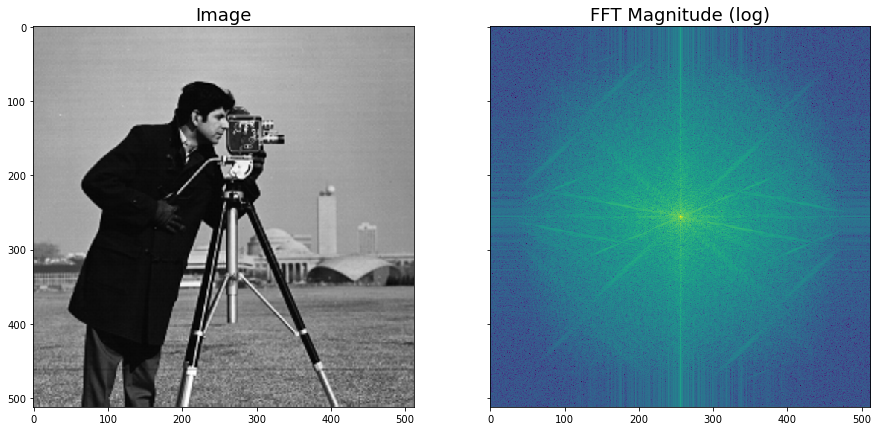

In [2]:
# First look at Image and corresponding FFT

image = camera()
image_fft = fftshift(fftn(image))

# Plot
fig, ax = plt.subplots(ncols=2, figsize=(15, 10), sharey=True)
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Image', fontdict=font)
ax[1].imshow(np.log(np.abs(image_fft))) # Notice the log transform!
ax[1].set_title('FFT Magnitude (log)', fontdict=font);

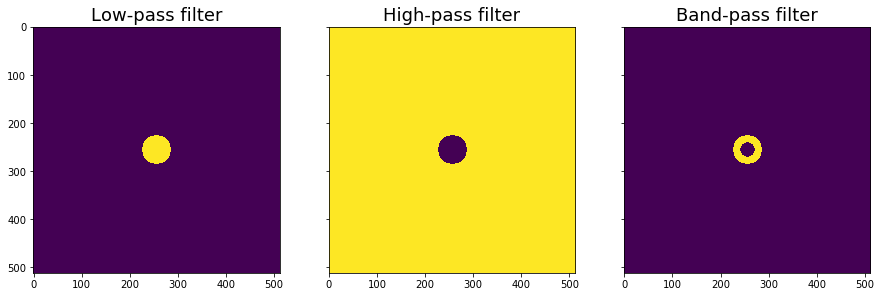

In [3]:
# Create some filters and plot them

from skimage.draw import circle

cutoff = 30 # Play with this value
center = (np.array(image.shape)[:2] / 2) - 0.5

# Low-pass filter
lpf = np.zeros_like(image)
lpf[circle(*center, cutoff)] = 1

# High-pass filter
hpf = np.ones_like(image)
hpf[circle(*center, cutoff)] = 0

# Band-pass filter
bpf = lpf.copy()
bpf[circle(*center, cutoff / 2)] = 0

# Plot
fig, ax = plt.subplots(ncols=3, figsize=(15, 10), sharey=True)
ax[0].imshow(lpf)
ax[0].set_title('Low-pass filter', fontdict=font)
ax[1].imshow(hpf)
ax[1].set_title('High-pass filter', fontdict=font)
ax[2].imshow(bpf)
ax[2].set_title('Band-pass filter', fontdict=font);

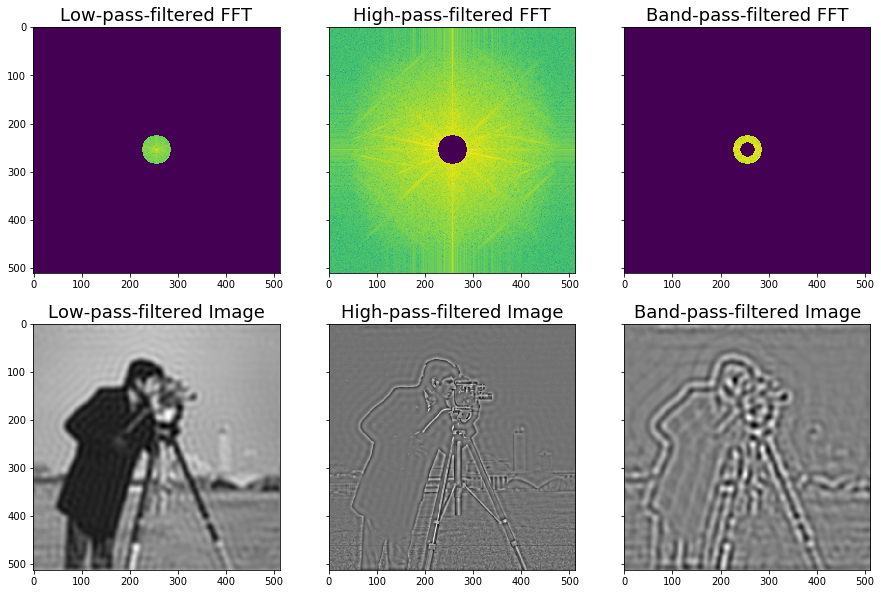

In [4]:
# Apply filters to the FFT
lp_filtered_fft = image_fft * lpf
hp_filtered_fft = image_fft * hpf
bp_filtered_fft = image_fft * bpf

# convert back to spatial domain from frequency domain
lp_filtered_image = ifftn(ifftshift(lp_filtered_fft))
hp_filtered_image = ifftn(ifftshift(hp_filtered_fft))
bp_filtered_image = ifftn(ifftshift(bp_filtered_fft))

lp_filtered_image = lp_filtered_image.real
hp_filtered_image = hp_filtered_image.real
bp_filtered_image = bp_filtered_image.real

# Plot
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15, 10), sharey=True)
offset = 10 ** -6 # for avoiding divide-by-zero error

ax[0, 0].imshow(np.log(np.abs(lp_filtered_fft) + offset))
ax[0, 0].set_title('Low-pass-filtered FFT', fontdict=font)
ax[0, 1].imshow(np.log(np.abs(hp_filtered_fft) + offset))
ax[0, 1].set_title('High-pass-filtered FFT', fontdict=font)
ax[0, 2].imshow(np.log(np.abs(bp_filtered_fft) + offset))
ax[0, 2].set_title('Band-pass-filtered FFT', fontdict=font)
ax[1, 0].imshow(lp_filtered_image, cmap='gray')
ax[1, 0].set_title('Low-pass-filtered Image', fontdict=font)
ax[1, 1].imshow(hp_filtered_image, cmap='gray')
ax[1, 1].set_title('High-pass-filtered Image', fontdict=font)
ax[1, 2].imshow(bp_filtered_image, cmap='gray')
ax[1, 2].set_title('Band-pass-filtered Image', fontdict=font);

There are a few things worth mentioning about these filters. First, low-pass filters tend to smooth out (blur) your signal, whereas high-pass filters tend to highlight sharp transitions (e.g., edges). Bandpass filters produce an effect that is somewhat in-between, highlighting edges while filtering out image noise (which usually shows up as high frequency components).

You'll also notice a ripple effect in the images. These **ringing artifacts** are typically considered undesirable, and occur because the sharp cutoff in the Frequency domain. To better understand why this happens, think about simply removing high or low frequencies from the square wave example we covered in lesson 2. If you subtract a sine wave from an image that contains a lot of flat regions and edges, you'll create ripples!

To avoid the ripple artifacts, we need to be a little more thoughtful about how we remove high (or low) frequencies from our images. There are many approaches for creating better frequency domain filters, but a really simple (and computationally fast) approach is to make use of our friend the gaussian filter!

Because the gaussian filter acts as a low-pass filter (that doesn't have a hard cutoff in the frequency domain), not only can we use it directly for that purpose, we can also perform some basic arithmetic to create high-pass and band-pass filters.

**To create a high-pass filter**, we subtract a gaussian-filtered image from the original.

**To create a band-pass filter**, we create two gaussian-filtered images where the gaussian kernels differ with respect to $\sigma$, then subtract the image filtered with the higher $\sigma$ from the other filtered image:

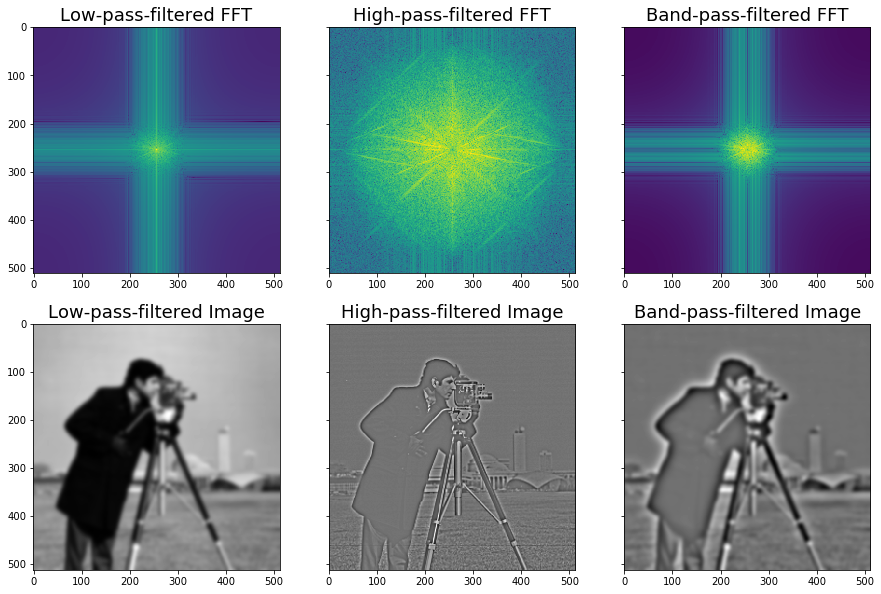

In [5]:
from skimage.filters import gaussian
from skimage import img_as_float

image = img_as_float(image)
gf_image = gaussian(image, 4) # low-pass filter
gf_image2 = gaussian(image, 12) # another low-pass filter

ghpf = image - gf_image # high-pass filter
gbpf = gf_image - gf_image2 # band-pass filter

glpf_fft = fftshift(fftn(gf_image))
ghpf_fft = fftshift(fftn(ghpf))
gbpf_fft = fftshift(fftn(gbpf))


# Plot
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15, 10), sharey=True)
offset = 10 ** -6 # for avoiding divide-by-zero error

ax[0, 0].imshow(np.log(np.abs(glpf_fft)))
ax[0, 0].set_title('Low-pass-filtered FFT', fontdict=font)
ax[0, 1].imshow(np.log(np.abs(ghpf_fft)))
ax[0, 1].set_title('High-pass-filtered FFT', fontdict=font)
ax[0, 2].imshow(np.log(np.abs(gbpf_fft)))
ax[0, 2].set_title('Band-pass-filtered FFT', fontdict=font)
ax[1, 0].imshow(gf_image, cmap='gray')
ax[1, 0].set_title('Low-pass-filtered Image', fontdict=font)
ax[1, 1].imshow(ghpf, cmap='gray')
ax[1, 1].set_title('High-pass-filtered Image', fontdict=font)
ax[1, 2].imshow(gbpf, cmap='gray')
ax[1, 2].set_title('Band-pass-filtered Image', fontdict=font);

Sometimes images are corrupted by some imaging artifact that occurs at very specific frequencies/orientations. Consider the `moonlanding.png` example:

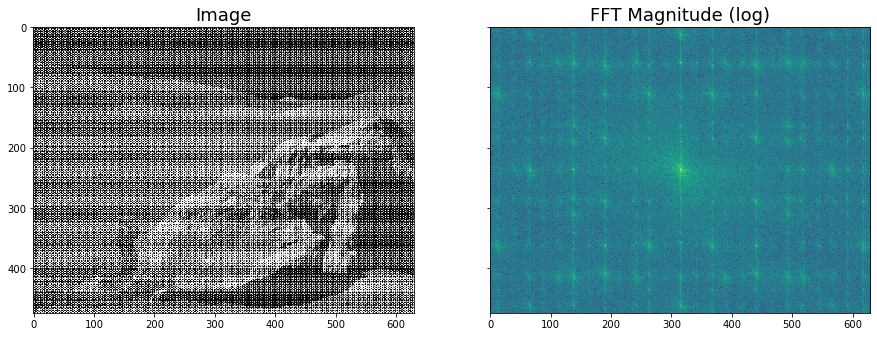

In [6]:
from skimage import io

image = io.imread('../data/moonlanding.png')
im_fft = fftshift(fftn(image))

im_fft_mag = np.abs(im_fft)

# Plot
fig, ax = plt.subplots(ncols=2, figsize=(15, 10), sharey=True)
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Image', fontdict=font)
ax[1].imshow(np.log(im_fft_mag))
ax[1].set_title('FFT Magnitude (log)', fontdict=font);

The regular, grid-like appearance of FFT magnitude spikes suggests the presence of a highly regular artifact in the source image. Zooming in on the image confirms this is the case:

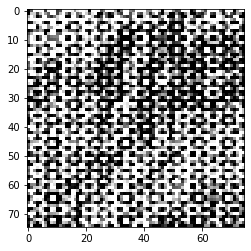

In [7]:
plt.imshow(image[200:275, 400:475], cmap='gray');

Is there a way we can remove the artifacts without losing our source image? If you look at the FFT, you notice that the potential noise peaks disappear close to the center, so one approach is to use a low-pass filter:

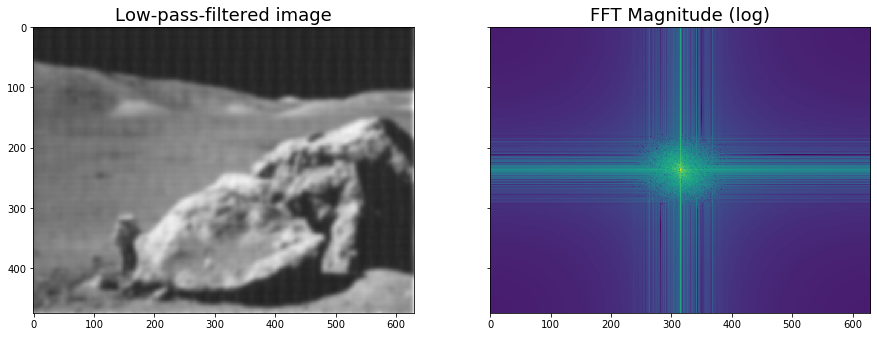

In [8]:
image_lpf = gaussian(image, 4)

im_fft_lpf = fftshift(fftn(image_lpf))

im_fft_mag_lpf = np.abs(im_fft_lpf)

# Plot
fig, ax = plt.subplots(ncols=2, figsize=(15, 10), sharey=True)
ax[0].imshow(image_lpf, cmap='gray')
ax[0].set_title('Low-pass-filtered image', fontdict=font)
ax[1].imshow(np.log(im_fft_mag_lpf))
ax[1].set_title('FFT Magnitude (log)', fontdict=font);

Indeed this filtered image looks much better, but losing so much of the high frequency components does make the image a bit blurry. What if we remove only the problematic high frequencies? Let us now work through the opening example for this workshop series (*Note: the code has been changed slightly from the original example to be a little easier to follow; the concepts and math are the same*).

We first need to find the high frequency peaks in the FFT and create a mask:

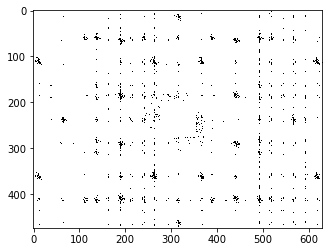

In [9]:
mask = im_fft_mag.copy()

# Exclude low frequencies
M, N = mask.shape
K = 40 # Value used to crop low frequencies
mask[M // 2 - K: M // 2 + K, N // 2 - K: N // 2 + K] = 0

# For remaining signal, set to 1 if less than 98pctl intensity
mask = mask < np.percentile(mask, 98)

# Look at peaks
plt.imshow(mask, cmap='gray');

Now we have a mask where only high frequencies with large values are set to `False`, and all other frequencies are set to `True`. Now we can multiply this mask with the original FFT to zero out the problematic peaks:

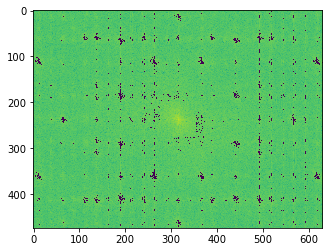

In [10]:
# Mask original FFT and look at magnitude
im_fft_nopeaks = mask * im_fft
plt.imshow(np.log(np.abs(im_fft_nopeaks)+offset)); # offset avoids divide-by-zero

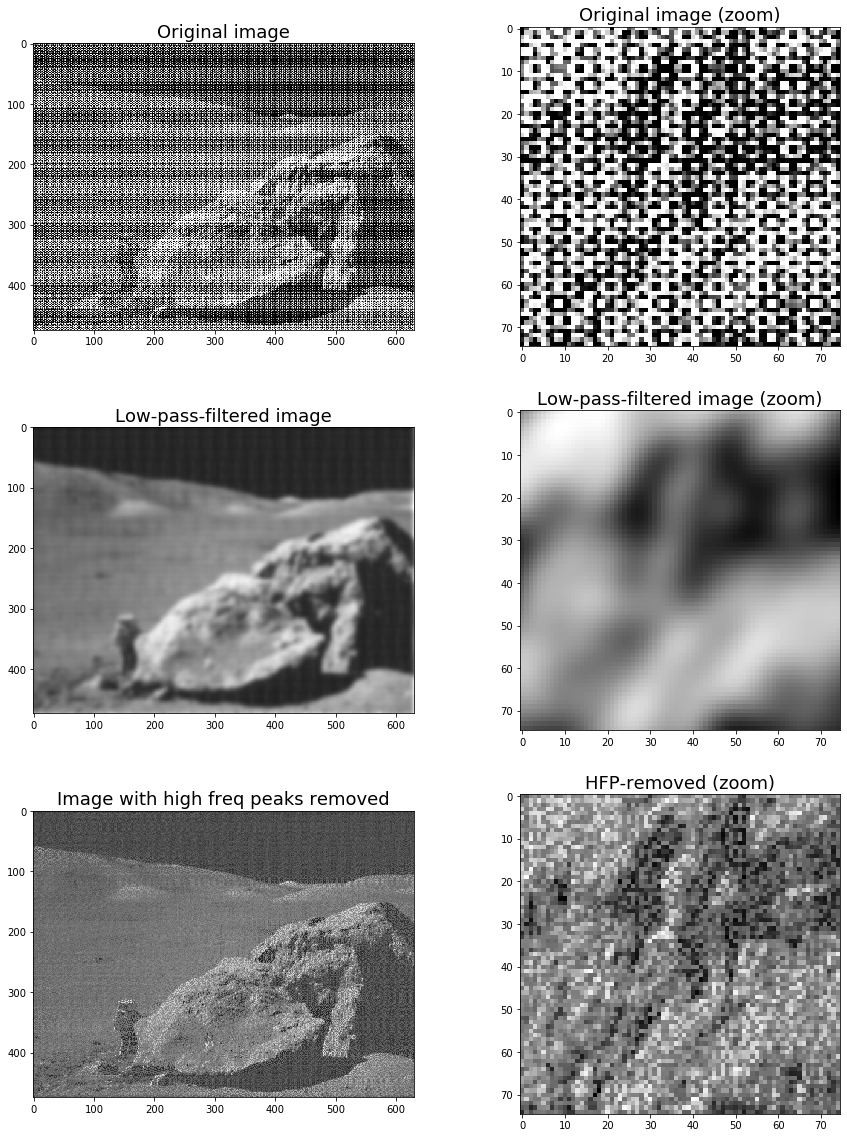

In [11]:
# Create new image from masked FFT
image_filtered = ifftn(ifftshift(im_fft_nopeaks))
image_filtered = np.real(image_filtered)

# Plot
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(15, 20))

ax[0,0].imshow(image, cmap='gray')
ax[0,0].set_title('Original image', fontdict=font)
ax[0,1].imshow(image[200:275, 400:475], cmap='gray')
ax[0,1].set_title('Original image (zoom)', fontdict=font)
ax[1,0].imshow(image_lpf, cmap='gray')
ax[1,0].set_title('Low-pass-filtered image', fontdict=font)
ax[1,1].imshow(image_lpf[200:275, 400:475], cmap='gray')
ax[1,1].set_title('Low-pass-filtered image (zoom)', fontdict=font)
ax[2,0].imshow(image_filtered, cmap='gray')
ax[2,0].set_title('Image with high freq peaks removed', fontdict=font)
ax[2,1].imshow(image_filtered[200:275, 400:475], cmap='gray')
ax[2,1].set_title('HFP-removed (zoom)', fontdict=font);

## Phase correlation

Recall from the last lesson that a signal that is shifted in phase will contain the same frequency magnitudes as the unshifted signal, but we can recover information about the phase shift in the frequency domain. This fact can be exploited to align images that differ only by a translation (e.g., a 2-D image shifted along the x and y axes).

Consider the following pair of images:

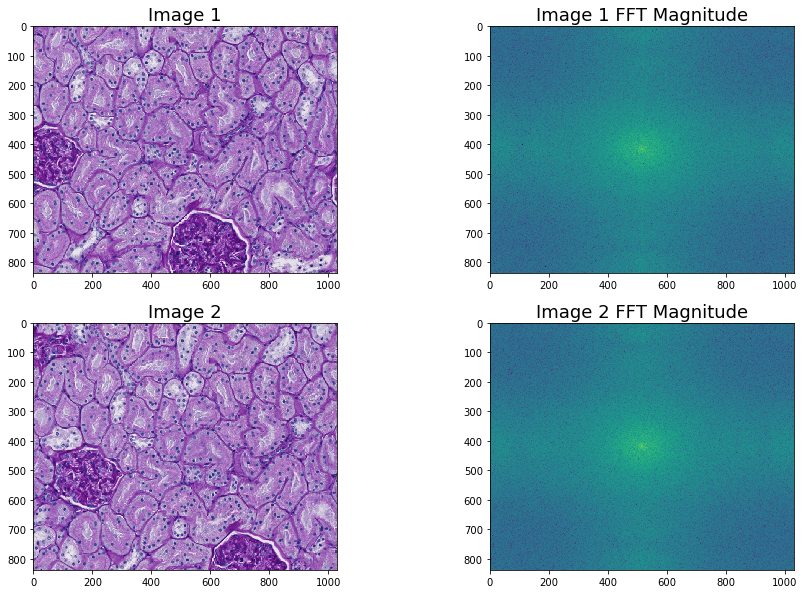

In [12]:
from skimage.color import rgb2gray

# Create image pair
image = io.imread('../data/bear_kidney.png')
col_shift = 137
row_shift = 82
image1 = image[row_shift:,col_shift:]
image2 = image[:-row_shift,:-col_shift]

# Take FFT Magnitude
image1_gray = rgb2gray(image1)
fft1 = fftshift(fftn(image1_gray))
image2_gray = rgb2gray(image2)
fft2 = fftshift(fftn(image2_gray))

# Plot
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))
ax[0,0].imshow(image1, cmap='gray')
ax[0,0].set_title('Image 1', fontdict=font)
ax[0,1].imshow(np.log(np.abs(fft1)))
ax[0,1].set_title('Image 1 FFT Magnitude', fontdict=font)
ax[1,0].imshow(image2, cmap='gray')
ax[1,0].set_title('Image 2', fontdict=font)
ax[1,1].imshow(np.log(np.abs(fft2)))
ax[1,1].set_title('Image 2 FFT Magnitude', fontdict=font);


You'll notice that the FFT magnitudes look very similar. This isn't surprising, as the images share mostly the same content. The phase information is actually quite different (although phase info is very hard to understand with the human eye).

**Phase correlation** can be used to recover the phase difference (xy translation) between the two images. This is a purely mathematical approach where you first take the cross-power spectrum of two images (a and b):

<center>$R = \Large\frac{G_a\circ G^\ast_b}{\vert G_a\circ G^\ast_b\vert}$</center>

Where $ G_a $ is the FFT of image a, and $ G^\ast_b $ is the complex conjugate of the FFT of image b. The $ \circ $ symbol indicates element-wise multiplication. The complex conjugate of a complex number has a real part that is equal to and a complex part is opposite in sign to the original number. For example, $ 5 + 3i $ is the complex conjugate of $ 5 - 3i $.

In Python, we calculate the cross-power spectrum like this:

In [13]:
fft2_cc = np.conjugate(fft2) # complex conjugate

numerator = fft1 * fft2_cc
denominator = np.abs(numerator)

cps = numerator/denominator

Once you have the cross power spectrum, you perform the inverse FFT on it:

In [14]:
cpsi = ifftshift(cps)
phase_corr = ifftn(cpsi).real

Finally, we look for the maximum signal in the resulting array:

In [15]:
row_coord, col_coord = np.where(phase_corr == phase_corr.max())

print(f'Peak correlation signal at ({row_coord[0]}, {col_coord[0]})')

Peak correlation signal at (756, 893)


Finally, compare the peak in the output array to the shape of the input images:

In [16]:
print(f'Row shift = {image1.shape[0] - row_coord[0]}')
print(f'Column shift = {image1.shape[1] - col_coord[0]}')

Row shift = 82
Column shift = 137


## Convolutions

### A quick refresher on array convolutions

One important way to identify features such as edges in images is to use convolutional filters. If you have had training in basic computational image analysis in the past, you probably have had some experience using convolutions and can skip over this section.

The first basic concept to know about array convolutions is that they transform an array by combining it with another array. The basic convolution operation entails summing the products of an element-wise multiplication:

<img src='../data/convolution_slides/Slide1.png'>

This operation is performed iteratively using a sliding window centered on every pixel in the original image. For example, let's convolve a vertical edge-detecting kernal with a simple image of an edge. In regions with all zeros, the kernel will produce all zeros:

<img src='../data/convolution_slides/Slide2.png'>
<img src='../data/convolution_slides/Slide3.png'>

And the same is true in regions with all 255:

<img src='../data/convolution_slides/Slide4.png'>

However in windows that span an edge, you will end up with a non-zero value:

<img src='../data/convolution_slides/Slide5.png'>

When we perform the convolution over the whole image, we can build up a map of the vertical edge:

<img src='../data/convolution_slides/Slide6.png'>

In a typical image-analysis context, the output values will typically be normalized (i.e., divided by the number of elements in the kernel), but the basic concept stands.

### Simple convolutions in Python

Now let's take a look at a simple convolution in Python, using the same kernel as in the above example:

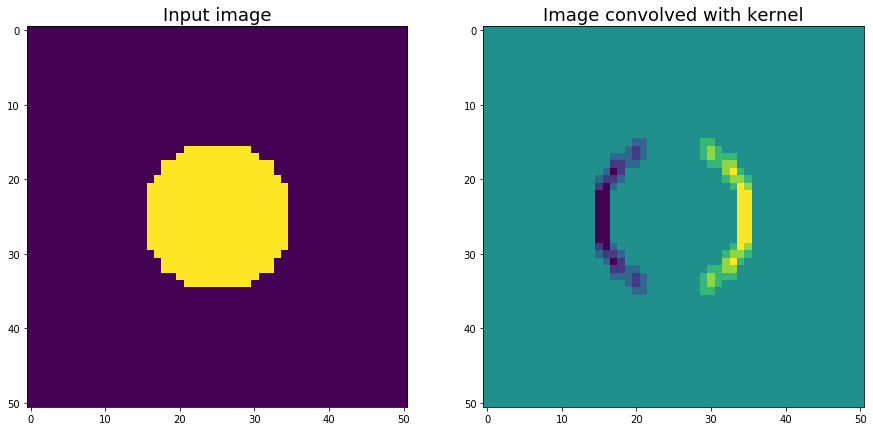

In [17]:
from scipy.ndimage import convolve

input_image = np.zeros((51,51))
circle_coords = circle(25,25,10)
input_image[circle_coords] = 1

kernel = [[-1,0,1],
          [-1,0,1],
          [-1,0,1]]


output_image = convolve(input_image, kernel)

fig, ax = plt.subplots(ncols=2, figsize=(15,8))
ax[0].imshow(input_image)
ax[0].set_title('Input image', fontdict=font)
ax[1].imshow(output_image)
ax[1].set_title('Image convolved with kernel', fontdict=font);

Here we see that our edge detector indeed picked up both negative and positive-slope edges.

You'll notice that the output values of the opposite sign of what we would expect (e.g., the left edge has negative values, whereas the right edge has positive values). This is because, when you perform a 2D convolution, your kernel is actually flipped in both x and y. We won't discuss the math behind that convention, just be aware that it happens.

So why are we talking about convolutions in the context of the FFT? Because <b><i>convolution in the spatial domain is equivalent to multiplication in the frequency domain</b></i>! The proof that this is true is here:

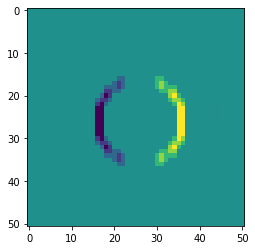

In [18]:
# kernel needs to be same size as array
# so we pad out with zeros
kernel_wpad = np.pad(kernel, ((0,48), (0,48)))

# take ffts of both kernel and input_image
f_input = fftn(input_image)
f_kernel = fftn(kernel_wpad)

# multipy the ffts
f_output = f_input * f_kernel

# convert back to spatial domain and take a look
output_image = ifftn(f_output)
plt.imshow(output_image.real);

Not lets look at what the image, kernel, and output image look like in both the spatial domain and the frequency domain, to get a better intuition for what is going on:

Text(0.5, 1.0, 'Output image FFT mag.')

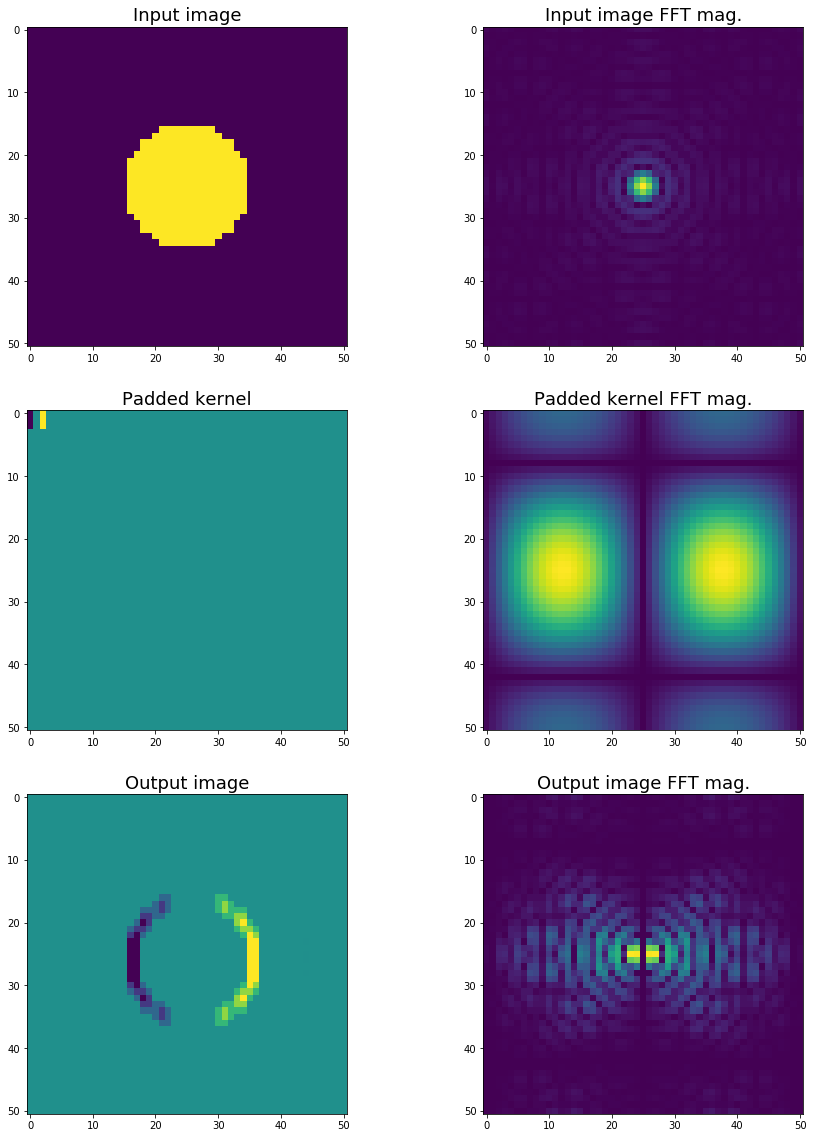

In [19]:
# Get FFT magnitudes
f_input_mag = np.abs(fftshift(f_input))
f_kernel_mag = np.abs(fftshift(f_kernel))
f_output_mag = np.abs(fftshift(f_output))

# Plot
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,20))

ax[0,0].imshow(input_image)
ax[0,0].set_title('Input image', fontdict=font)
ax[0,1].imshow(f_input_mag)
ax[0,1].set_title('Input image FFT mag.', fontdict=font)
ax[1,0].imshow(kernel_wpad)
ax[1,0].set_title('Padded kernel', fontdict=font)
ax[1,1].imshow(f_kernel_mag)
ax[1,1].set_title('Padded kernel FFT mag.', fontdict=font)
ax[2,0].imshow(output_image.real)
ax[2,0].set_title('Output image', fontdict=font)
ax[2,1].imshow(f_output_mag)
ax[2,1].set_title('Output image FFT mag.', fontdict=font)

The relationship between convolution and the FFT is not just interesting trivia. It turns out that, because the FFT algorithm has been studied, improved and highly optimized over the years, performing convolutions by the FFT method is often *significantly* faster than the conventional sliding-window approach. This is especially true for very large images.

## Challenges

In [20]:
kernel = [[-1,-1,-1],
          [-1, 8,-1],
          [-1,-1,-1]]